In [1]:
# Here is the tutorial that shows how to scrape table from pdf: 
# https://towardsdatascience.com/scraping-table-data-from-pdf-files-using-a-single-line-in-python-8607880c750
# Here is the tutorial the choropleth is based on: https://plotly.com/python/choropleth-maps/
# Here is the tutorial the geopandas shape plotting is based on: https://github.com/joncutrer/geopandas-tutorial/blob/master/geopandas-us-map.ipynb
# Here is another tutorial that might be helpful: https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6

# load packages
import tabula
import kaleido
import plotly.graph_objects as go
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

# plots not rendering fix
import plotly.io as pio
pio.renderers.default='notebook'

In [2]:
# read the shapefile
states = geopandas.read_file('us_shp/cb_2018_us_state_20m.shp')
type(states)

geopandas.geodataframe.GeoDataFrame

In [3]:
# preview the dataframe
states

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."
5,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05314 41.11446, -104.05245 41.2..."
6,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704..."
7,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868896030,4922382562,"MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
9,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."


<Axes: >

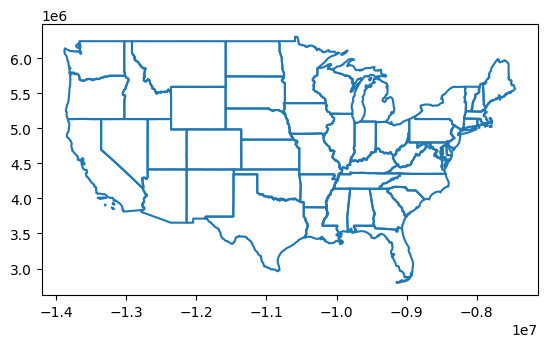

In [4]:
# reproject coordinates to Mercator
states = states.to_crs("EPSG:3395")

# remove Hawaii, Alaska, Puerto Rico for now
cont_states = states[~states.STUSPS.isin(['HI','AK','PR'])]

# get boundary plot
cont_states.boundary.plot()

In [5]:
# scrape Table B.1 into the data frame
from tabula.io import read_pdf
file1 = "https://fns-prod.azureedge.us/sites/default/files/resource-files/snap-tech-partrate2017-2019.pdf"
table = read_pdf(file1,pages=79)
df = table[0]
print(df.head())

  Eligible people    Unnamed: 0 Unnamed: 1 Unnamed: 2       Lower bound of   
0     (thousands)           NaN      State        NaN  confidence interval  \
1           1,575      Illinois        NaN          *                   94   
2             514        Oregon        NaN          *                   93   
3             124  Rhode Island        NaN          *                   93   
4             107      Delaware        NaN          *                   93   

              FY 2019       Upper bound of  
0  participation rate  confidence interval  
1                 100                  100  
2                 100                  100  
3                 100                  100  
4                 100                  100  


In [6]:
# Create a dictionary to map the old column names to new column names
new_names = {
    'Eligible people': 'eligible_thousands',
    'Unnamed: 0': 'state',
    'Unnamed: 1': 'placeholder',
    'Unnamed: 2': 'significant',
    'Lower bound of': 'lower_bound',
    'FY 2019': 'rate',
    'Upper bound of': 'upper_bound'
}

# Use the `rename()` method to rename the columns of the DataFrame
df = df.rename(columns=new_names)

# Use the `drop()` method to clean the dataframe
df = df.drop(0) # delete the first row
df = df.drop(columns=['placeholder']) # delete the Placeholder column that had no values

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

# Print the first few rows of the updated DataFrame to check
print(df.head())

  eligible_thousands         state significant lower_bound rate upper_bound
0              1,575      Illinois           *          94  100         100
1                514        Oregon           *          93  100         100
2                124  Rhode Island           *          93  100         100
3                107      Delaware           *          93  100         100
4                404    New Mexico           *          93  100         100


In [7]:
# Define a dictionary that maps state names to their postal codes
state_codes = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Use the `map()` method to apply the state_codes dictionary to the state column of the DataFrame
df['code'] = df['state'].map(state_codes)

# Move the "Code" column from final position to position 2
column_to_move = df.pop('code')
df.insert(2, 'code', column_to_move)

# Print the first few rows of the updated DataFrame to check the mapping
print(df.head())

  eligible_thousands         state code significant lower_bound rate   
0              1,575      Illinois   IL           *          94  100  \
1                514        Oregon   OR           *          93  100   
2                124  Rhode Island   RI           *          93  100   
3                107      Delaware   DE           *          93  100   
4                404    New Mexico   NM           *          93  100   

  upper_bound  
0         100  
1         100  
2         100  
3         100  
4         100  


In [8]:
# Create calculated columns for not participating and participating numbers
df['eligible_thousands'] = df['eligible_thousands'].str.replace(',', '').astype(float)
df['eligible_thousands'] = pd.to_numeric(df['eligible_thousands'])
df['rate'] = pd.to_numeric(df['rate'])
df['not_participating_thousands'] = df['eligible_thousands'] - (df['eligible_thousands']/df['rate'])
df['not_participating_actual'] = df['not_participating_thousands']*1000
df.head()

,eligible_thousands,state,code,significant,lower_bound,rate,upper_bound,not_participating_thousands,not_participating_actual
0,1575.0,Illinois,IL,*,94,100,100,1559.25,1559250.0
1,514.0,Oregon,OR,*,93,100,100,508.86,508860.0
2,124.0,Rhode Island,RI,*,93,100,100,122.76,122760.0
3,107.0,Delaware,DE,*,93,100,100,105.93,105930.0
4,404.0,New Mexico,NM,*,93,100,100,399.96,399960.0


In [10]:
# create visualization for total N
fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = df['not_participating_actual'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = [[0.0, "rgb(235,240,255)"],
                [0.1111111111111111, "rgb(214,225,255)"],
                [0.2222222222222222, "rgb(194,210,255)"],
                [0.3333333333333333, "rgb(173,195,255)"],
                [0.4444444444444444, "rgb(153,180,255)"],
                [0.5555555555555556, "rgb(133,165,255)"],
                [0.6666666666666666, "rgb(112,150,255)"],
                [0.7777777777777778, "rgb(92,135,255)"],
                [0.8888888888888888, "rgb(71,120,255)"],
                [1.0, "rgb(51,105,255)"]],
    colorbar_title = "Estimated Eligible Individuals not Enrolled"
))

fig.update_layout(
    title_text = 'FY2019 Individuals Eligible but Not Participating in SNAP',
    geo_scope='usa', # limit map scope to USA
    annotations = [dict(
        x=0,
        y=0,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://fns-prod.azureedge.us/sites/default/files/resource-files/snap-tech-partrate2017-2019.pdf">\
            FY19 SNAP Participation Estimates</a>',
        showarrow = False
    )]
)


fig.show()

import plotly.io as pio
pio.write_image(fig, 'images/fig1.svg')
fig.write_image("images/fig1.svg")

In [32]:
# create visualization for total N
fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # spatial coordinates
    z = df['rate'].astype(float), # data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Participation Rate"

))


fig.update_layout(
    title_text = 'FY2019 Rate of Eligible Individuals Enrolled in SNAP',
    geo_scope='usa', # limit map scope to USA
        annotations = [dict(
        x=0,
        y=0,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://fns-prod.azureedge.us/sites/default/files/resource-files/snap-tech-partrate2017-2019.pdf">\
            FY19 SNAP Participation Estimates</a>',
        showarrow = False
    )]
)

fig.show()